<a href="https://colab.research.google.com/github/Geoffrey256/meta-learning-final-year/blob/main/reptile_for_medical_waste.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os

# Dataset base path
base_path = "/content/drive/MyDrive/Year3 /Datasets/medical_dataset/Medical_Waste_Dataset"

# Training directory
train_path = os.path.join(base_path, "train")

# List class folders inside train
class_names = sorted(os.listdir(train_path))
print("Available Classes:", class_names)

Available Classes: ['chemical', 'general waste', 'infectious waste', 'pharmacutical', 'sharps']


In [ ]:
import cv2
from collections import Counter

# Dictionary to count image sizes
size_counter = Counter()

# Loop through class folders and sample sizes
for class_name in class_names:
    class_dir = os.path.join(train_path, class_name)
    files_checked = 0

    for img_file in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_file)
        img = cv2.imread(img_path)

        if img is not None:
            size_counter[img.shape[:2]] += 1  # (height, width)
            files_checked += 1

        if files_checked >= 10:  # Check only first 10 images per class
            break

print("Image sizes (height x width):")
for size, count in size_counter.items():
    print(f"{size}: {count} images")

Image sizes (height x width):
(224, 224): 50 images


In [ ]:
import cv2
import numpy as np
from tqdm import tqdm

IMG_SIZE = 84  # target image size
dataset = {}   # class-wise dictionary of images

for class_name in class_names:
    class_dir = os.path.join(train_path, class_name)
    images = []

    for img_file in tqdm(os.listdir(class_dir), desc=f"Loading {class_name}"):
        img_path = os.path.join(class_dir, img_file)
        img = cv2.imread(img_path)

        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32) / 255.0  # normalize to [0, 1]
            images.append(img)

    dataset[class_name] = images

# Print number of images per class
for cls in dataset:
    print(f"{cls}: {len(dataset[cls])} images")

Loading sharps: 100%|██████████| 364/364 [00:02<00:00, 160.99it/s]

chemical: 24 images
general waste: 76 images
infectious waste: 144 images
pharmacutical: 160 images
sharps: 364 images


**Build a Task Sampler (Support & Query Set Generator)**

In [ ]:
import random

def create_episode(dataset, n_way=5, k_shot=1, q_query=5):
    """
    Creates one episode with support and query sets.

    Args:
        dataset (dict): Class-wise image dictionary.
        n_way (int): Number of classes per task.
        k_shot (int): Number of support images per class.
        q_query (int): Number of query images per class.

    Returns:
        support_x, support_y, query_x, query_y: Lists of images and labels
    """
    selected_classes = random.sample(list(dataset.keys()), n_way)
    support_x, support_y = [], []
    query_x, query_y = [], []

    for label_idx, class_name in enumerate(selected_classes):
        images = random.sample(dataset[class_name], k_shot + q_query)
        support_imgs = images[:k_shot]
        query_imgs = images[k_shot:]

        support_x.extend(support_imgs)
        support_y.extend([label_idx] * k_shot)

        query_x.extend(query_imgs)
        query_y.extend([label_idx] * q_query)

    # Convert to numpy arrays
    support_x = np.array(support_x)
    support_y = np.array(support_y)
    query_x = np.array(query_x)
    query_y = np.array(query_y)

    return support_x, support_y, query_x, query_y

**Build the Reptile Model Architecture & Training Loop**

In [ ]:
import tensorflow as tf

def build_cnn_model(input_shape=(84, 84, 3), num_classes=5):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

**Compile and test CNN model on a sample episode**

In [ ]:
import tensorflow as tf

# Step 1: Build CNN model with explicit Input layer to avoid warnings
def build_cnn_model(input_shape=(84, 84, 3), num_classes=5):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=input_shape),  # Explicit Input layer
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Step 2: Compile the model
# model = build_cnn_model(input_shape=(84, 84, 3), num_classes=5)
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#     loss='sparse_categorical_crossentropy',
#     metrics=['accuracy']
# )

# Create and compile model
model = build_cnn_model(input_shape=(84, 84, 3),num_classes=5)
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Initialize meta weights
meta_weights = model.get_weights()


# Step 3: Generate one episode (you should have this function from before)
support_x, support_y, query_x, query_y = create_episode(dataset, n_way=5, k_shot=1, q_query=5)

# Step 4: Train the model on support set for 1 epoch (quick test)
model.fit(support_x, support_y, epochs=1)

/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2000 - loss: 1.6013


**Code Weight**

In [ ]:
import copy

# Helper: Get weights (deep copy)
def get_weights(model):
    return [w.numpy() for w in model.trainable_weights]

# Helper: Set weights
def set_weights(model, weights):
    for var, w in zip(model.trainable_weights, weights):
        var.assign(w)

# Helper: Interpolate weights between initial and post-task weights
def interpolate_weights(old_weights, new_weights, epsilon=0.1):
    return [old + epsilon * (new - old) for old, new in zip(old_weights, new_weights)]

In [ ]:
import random
import tensorflow as tf
import os
import numpy as np

# Configs
num_iterations = 1000        # Number of meta-training steps
inner_epochs = 1             # How long we train on each task (inner loop)
inner_batch_size = 8         # Batch size per task
epsilon = 0.1                # Step size for Reptile update
n_way = 3                    # Number of classes per task
k_shot = 5                   # Number of images per class (support set)
query_shot = 2               # Number of images per class (query set)

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

def sample_task(dataset_path, n_way=3, k_shot=5, query_shot=2, img_size=(84, 84)):
    class_names = random.sample(os.listdir(dataset_path), n_way)
    support_images = []
    support_labels = []
    query_images = []
    query_labels = []

    label_map = {name: i for i, name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(dataset_path, class_name)
        image_files = os.listdir(class_dir)
        selected = random.sample(image_files, k_shot + query_shot)

        support = selected[:k_shot]
        query = selected[k_shot:]

        for img_name in support:
            img_path = os.path.join(class_dir, img_name)
            img = tf.keras.utils.load_img(img_path, target_size=img_size)
            img = tf.keras.utils.img_to_array(img) / 255.0
            support_images.append(img)
            support_labels.append(label_map[class_name])

        for img_name in query:
            img_path = os.path.join(class_dir, img_name)
            img = tf.keras.utils.load_img(img_path, target_size=img_size)
            img = tf.keras.utils.img_to_array(img) / 255.0
            query_images.append(img)
            query_labels.append(label_map[class_name])

    support_dataset = tf.data.Dataset.from_tensor_slices((support_images, support_labels))
    query_dataset = tf.data.Dataset.from_tensor_slices((query_images, query_labels))

    support_dataset = support_dataset.shuffle(100).batch(inner_batch_size)
    query_dataset = query_dataset.shuffle(100).batch(inner_batch_size)

    return support_dataset, query_dataset

In [ ]:
optimizer = tf.keras.optimizers.Adam()

# Main Reptile training loop
for iteration in range(num_iterations):
    # Step 1: Sample a task (N-way K-shot)
    support_ds, _ = sample_task(
        dataset_path="/content/drive/MyDrive/Year3 /Datasets/medical_dataset/Medical_Waste_Dataset/train",
        n_way=n_way, k_shot=k_shot, query_shot=query_shot
    )

    # Step 2: Save the initial weights
    old_weights = get_weights(model)

    # Step 3: Inner loop training on the support set
    for epoch in range(inner_epochs):
        for x_batch, y_batch in support_ds:
            with tf.GradientTape() as tape:
                logits = model(x_batch, training=True)
                loss = tf.keras.losses.sparse_categorical_crossentropy(y_batch, logits, from_logits=True)
                loss = tf.reduce_mean(loss)
            grads = tape.gradient(loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

    # Step 4: Get new weights after the inner update
    new_weights = get_weights(model)

    # Step 5: Reptile update: Move original weights toward new ones
    updated_weights = interpolate_weights(old_weights, new_weights, epsilon=epsilon)
    set_weights(model, updated_weights)

    # Logging progress
    if (iteration + 1) % 100 == 0 or iteration == 0:
        print(f"Iteration {iteration+1}/{num_iterations} done.")

Iteration 1/1000 done.
Iteration 100/1000 done.
Iteration 200/1000 done.
Iteration 300/1000 done.
Iteration 400/1000 done.
Iteration 500/1000 done.
Iteration 600/1000 done.
Iteration 700/1000 done.
Iteration 800/1000 done.
Iteration 900/1000 done.
Iteration 1000/1000 done.


In [ ]:
def evaluate_reptile_task(model, dataset_path, n_way=3, k_shot=5, query_shot=5, img_size=(84, 84)):
    # Step 1: Sample task from validation or test set
    support_ds, query_ds = sample_task(
        dataset_path, n_way=n_way, k_shot=k_shot, query_shot=query_shot, img_size=img_size
    )

    # Step 2: Create a copy of the model for adaptation
    eval_model = tf.keras.models.clone_model(model)
    eval_model.set_weights(get_weights(model))

    # Step 3: Fine-tune the copied model on support set
    optimizer = tf.keras.optimizers.Adam()
    for x_batch, y_batch in support_ds:
        with tf.GradientTape() as tape:
            logits = eval_model(x_batch, training=True)
            loss = tf.keras.losses.sparse_categorical_crossentropy(y_batch, logits, from_logits=True)
            loss = tf.reduce_mean(loss)
        grads = tape.gradient(loss, eval_model.trainable_weights)
        optimizer.apply_gradients(zip(grads, eval_model.trainable_weights))

    # Step 4: Evaluate on query set
    total = 0
    correct = 0
    for x_batch, y_batch in query_ds:
        logits = eval_model(x_batch, training=False)
        preds = tf.argmax(logits, axis=1)
        correct += tf.reduce_sum(tf.cast(preds == tf.cast(y_batch, tf.int64), tf.int32)).numpy()
        total += y_batch.shape[0]

    accuracy = correct / total
    print(f"Meta-Test Accuracy on New Task: {accuracy * 100:.2f}%")

# Example call
evaluate_reptile_task(
    model,
    dataset_path="/content/drive/MyDrive/Year3 /Datasets/medical_dataset/Medical_Waste_Dataset/test",
    n_way=3, k_shot=5, query_shot=5
)

ValueError: Sample larger than population or is negative

In [ ]:
# def create_base_model(num_classes):
#     model = tf.keras.Sequential([
#         tf.keras.layers.Input(shape=(84, 84, 3)),
#         tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
#         tf.keras.layers.MaxPooling2D(),
#         tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#         tf.keras.layers.MaxPooling2D(),
#         tf.keras.layers.Flatten(),
#         tf.keras.layers.Dense(128, activation='relu'),
#         tf.keras.layers.Dense(num_classes)  # No softmax: logits used for sparse_categorical_crossentropy with from_logits=True
#     ])
#     return model

def create_base_model(num_classes=5):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(224, 224, 3)),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes)  # no softmax if using from_logits=True
    ])
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    return model



**Modify Reptile Training Loop to Log Metrics**

In [ ]:
import os
import random
import tensorflow as tf

# Define dataset path
train_ds = "/content/drive/MyDrive/Year3 /Datasets/medical_dataset/Medical_Waste_Dataset/train"

def sample_task(dataset_path, num_classes=5, shots=5, img_size=(224, 224), batch_size=16):
    class_names = os.listdir(dataset_path)
    selected_classes = random.sample(class_names, num_classes)

    support_images = []
    support_labels = []
    query_images = []
    query_labels = []

    label_map = {cls_name: idx for idx, cls_name in enumerate(selected_classes)}

    for cls_name in selected_classes:
        cls_path = os.path.join(dataset_path, cls_name)
        image_paths = [os.path.join(cls_path, fname) for fname in os.listdir(cls_path)]
        selected_images = random.sample(image_paths, shots + 1)  # 1 for query

        for i, img_path in enumerate(selected_images):
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
            img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
            label = label_map[cls_name]

            if i < shots:
                support_images.append(img)
                support_labels.append(label)
            else:
                query_images.append(img)
                query_labels.append(label)

    support_ds = tf.data.Dataset.from_tensor_slices((support_images, support_labels)).batch(batch_size)
    query_ds = tf.data.Dataset.from_tensor_slices((query_images, query_labels)).batch(batch_size)

    return support_ds, query_ds



model = create_base_model(num_classes=5)
meta_weights = model.get_weights()

support_ds, query_ds = sample_task(train_ds, num_classes=5, shots=5)
model.set_weights(meta_weights)
model.fit(support_ds, epochs=1, verbose=0)


# # Run sample task
# support_ds, query_ds = sample_task(train_ds, num_classes=5, shots=5)
# model.set_weights(meta_weights)
# model.fit(support_ds, epochs=1, verbose=0)


In [ ]:
import os
import random
import tensorflow as tf

def sample_task(dataset_path, num_classes=5, shots=5, img_size=(224, 224), batch_size=16):
    class_names = os.listdir(dataset_path)
    selected_classes = random.sample(class_names, num_classes)

    support_images = []
    support_labels = []
    query_images = []
    query_labels = []

    label_map = {cls_name: idx for idx, cls_name in enumerate(selected_classes)}

    for cls_name in selected_classes:
        cls_path = os.path.join(dataset_path, cls_name)
        image_paths = [os.path.join(cls_path, fname) for fname in os.listdir(cls_path)]
        selected_images = random.sample(image_paths, shots + 1)  # 1 for query

        for i, img_path in enumerate(selected_images):
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
            img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
            label = label_map[cls_name]

            if i < shots:
                support_images.append(img)
                support_labels.append(label)
            else:
                query_images.append(img)
                query_labels.append(label)

    support_ds = tf.data.Dataset.from_tensor_slices((support_images, support_labels)).batch(batch_size)
    query_ds = tf.data.Dataset.from_tensor_slices((query_images, query_labels)).batch(batch_size)

    return support_ds, query_ds

support_ds, query_ds = sample_task(train_ds, num_classes=5, shots=5)
model.set_weights(meta_weights)
model.fit(support_ds, epochs=1, verbose=0)



In [ ]:
# Load final weights into model
model.set_weights(meta_weights)

# Evaluate on 10 new few-shot tasks
eval_accuracies = []

for _ in range(100):
    support_ds, query_ds = sample_task(train_path, num_classes=5, shots=5)
    model.set_weights(meta_weights)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(support_ds, epochs=1, verbose=0)
    meta_weights = model.get_weights()  # Reptile update


base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet',
                                               pooling='avg')

for layer in base_model.layers:
    layer.trainable = False  # Freeze base

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5, activation='softmax')
])




# for _ in range(100):
#     support_ds, query_ds = sample_task(train_ds, num_classes=5, shots=5)
#     model.fit(support_ds, epochs=1, verbose=0)

#     correct = 0
#     total = 0

#     for x_batch, y_batch in query_ds:
#         logits = model(x_batch, training=False)
#         preds = tf.argmax(logits, axis=1)
#         y_batch = tf.cast(y_batch, tf.int64)
#         correct += tf.reduce_sum(tf.cast(preds == y_batch, tf.int32)).numpy()
#         total += y_batch.shape[0]

#     eval_accuracy = correct / total
#     eval_accuracies.append(eval_accuracy)

# # Print average accuracy over evaluation tasks
# avg_eval_accuracy = sum(eval_accuracies) / len(eval_accuracies)
# print(f"Average Evaluation Accuracy over 10 tasks: {avg_eval_accuracy:.4f}")


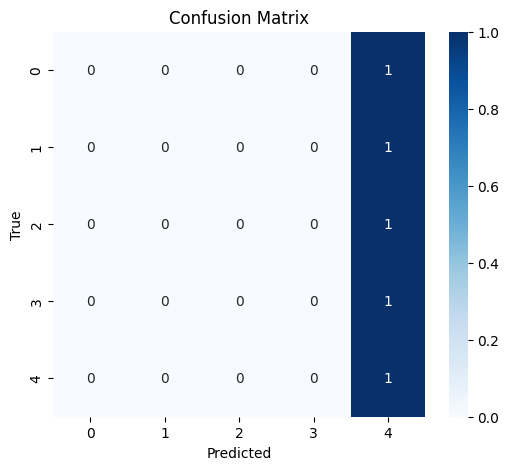

Accuracy: 0.2000
Recall (macro): 0.2000
F1-score (macro): 0.0667

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.20      1.00      0.33         1

    accuracy                           0.20         5
   macro avg       0.04      0.20      0.07         5
weighted avg       0.04      0.20      0.07         5



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, f1_score
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, f1_score


y_true_all = []
y_pred_all = []

for x_batch, y_batch in query_ds:
    logits = model(x_batch, training=False)
    preds = tf.argmax(logits, axis=1)

    y_true_all.extend(y_batch.numpy())
    y_pred_all.extend(preds.numpy())





# Confusion Matrix
cm = confusion_matrix(y_true_all, y_pred_all)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Evaluation Metrics
accuracy = accuracy_score(y_true_all, y_pred_all)
recall = recall_score(y_true_all, y_pred_all, average='macro')
f1 = f1_score(y_true_all, y_pred_all, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1-score (macro): {f1:.4f}")
print("\nClassification Report:\n")
print(classification_report(y_true_all, y_pred_all))


In [ ]:
import pickle

model.save("model.h5")


In [ ]:
import pickle

# Save weights as list
weights = model.get_weights()
with open("model_weights.pkl", "wb") as f:
    pickle.dump(weights, f)


In [ ]:
# import matplotlib.pyplot as plt
# import tensorflow as tf

# train_ds = "/content/drive/MyDrive/Year3 /Datasets/medical_dataset/Medical_Waste_Dataset/train"

# # Re-initialize the base model (if not already)
# model = create_base_model(num_classes=5)

# # Initialize meta weights from the base model
# meta_weights = model.get_weights()

# # Set your meta-learning rate
# meta_step_size = 0.1

# # Logging lists
# losses = []
# accuracies = []

# # Reptile training loop
# for iteration in range(1000):
#     model.set_weights(meta_weights)

#     # Sample task
#     support_ds, query_ds = sample_task(train_ds, num_classes=5, shots=5)

#     # Train on support set
#     model.fit(support_ds, epochs=1, verbose=0)

#     # Evaluate on query set
#     correct = 0
#     total = 0
#     loss_metric = tf.keras.metrics.Mean()

#     for x_batch, y_batch in query_ds:
#         logits = model(x_batch, training=False)
#         loss = tf.keras.losses.sparse_categorical_crossentropy(
#             y_batch, logits, from_logits=True
#         )
#         preds = tf.argmax(logits, axis=1)
#         y_batch = tf.cast(y_batch, tf.int64)
#         correct += tf.reduce_sum(tf.cast(preds == y_batch, tf.int32)).numpy()
#         total += y_batch.shape[0]
#         loss_metric.update_state(loss)

#     accuracy = correct / total
#     losses.append(loss_metric.result().numpy())
#     accuracies.append(accuracy)

#     # Meta-update: update meta-weights
#     new_weights = model.get_weights()
#     meta_weights = [(1 - meta_step_size) * old + meta_step_size * new
#                     for old, new in zip(meta_weights, new_weights)]

#     if (iteration + 1) % 100 == 0:
#         print(f"Iteration {iteration + 1}/1000 - Loss: {loss_metric.result():.4f} - Accuracy: {accuracy:.4f}")


TypeError: sample_task() got an unexpected keyword argument 'num_classes'

**version 2**

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
img_size = (224, 224)
train_path = "/content/drive/MyDrive/Datasets/Extracted/Pharmaceutical_and_Biomedical_Waste"
num_meta_iterations = 100  # ↑ Increase this
num_classes = 5
shots = 5


In [ ]:
def build_model(num_classes=5):
    base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='avg')
    base_model.trainable = False

    model = Sequential([
        base_model,
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model


In [ ]:
def sample_task(data_path, num_classes=5, shots=5):
    class_names = os.listdir(data_path)
    selected_classes = random.sample(class_names, num_classes)

    support_images, support_labels = [], []
    query_images, query_labels = [], []

    for idx, cls in enumerate(selected_classes):
        class_path = os.path.join(data_path, cls)
        all_images = os.listdir(class_path)
        selected_images = random.sample(all_images, shots * 2)  # 2x shots (support + query)

        for i in range(shots):
            img = image.load_img(os.path.join(class_path, selected_images[i]), target_size=img_size)
            img = image.img_to_array(img) / 255.0
            img = tf.image.random_flip_left_right(img)
            img = tf.image.random_brightness(img, max_delta=0.1)
            support_images.append(img)
            support_labels.append(idx)

        for i in range(shots, shots * 2):
            img = image.load_img(os.path.join(class_path, selected_images[i]), target_size=img_size)
            img = image.img_to_array(img) / 255.0
            img = tf.image.random_flip_left_right(img)
            img = tf.image.random_brightness(img, max_delta=0.1)
            query_images.append(img)
            query_labels.append(idx)

    support_ds = tf.data.Dataset.from_tensor_slices((np.array(support_images), np.array(support_labels))).batch(5)
    query_ds = tf.data.Dataset.from_tensor_slices((np.array(query_images), np.array(query_labels))).batch(5)

    return support_ds, query_ds


In [ ]:
# Initialize model and build it with dummy input
model = build_model(num_classes)
model.build(input_shape=(None, 224, 224, 3))
meta_weights = model.get_weights()

# Meta-training loop
for iteration in range(num_meta_iterations):
    support_ds, query_ds = sample_task(train_path, num_classes=num_classes, shots=shots)

    # Set model weights and compile for each task
    model.set_weights(meta_weights)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train on the support set
    model.fit(support_ds, epochs=1, verbose=0)

    # Get new weights after training on this task
    new_weights = model.get_weights()

    # Reptile update: blend old and new weights
    updated_weights = [meta_w + 0.1 * (new_w - meta_w) for meta_w, new_w in zip(meta_weights, new_weights)]
    meta_weights = updated_weights

    if iteration % 10 == 0:
        print(f"Completed {iteration}/{num_meta_iterations} iterations")


ValueError: Sample larger than population or is negative